# Match glider observation with floats and ships profiles

In [1]:
import h5py
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import pyarrow as pa
import matplotlib.pyplot as plt
import polars as pl
import re
import xarray as xr

In [2]:
#Simply change the working directory to the project directory

import os

current_dir = os.getcwd()
parent_parent_dir = os.path.dirname(current_dir)
os.chdir(parent_parent_dir)

# Now the working directory is set to the project directory
print("Current working directory:", os.getcwd())

Current working directory: c:\Users\flapet\OneDrive - NOC\Documents\IDAPro\lib\db_building


Write a function that save the .mat main table as a parquet file

In [3]:
def read_mat_write_parquet(filepath, save_folder, main_rep = 'gdat'):
    #Open the file with h5py library, it creates a group variable, which is similar as a dataset from a nc import
    file = h5py.File(filepath, 'r')
    #store the name of the file
    path_with_extension = os.path.basename(filepath)
    dataset_name, _ = os.path.splitext(path_with_extension)
    #extract the main repertory
    gdat = file[main_rep]
    #list all the variables inside the gdat group
    colnames = list(gdat.keys())
    #We then need to check which variable has the intended number of observation. The variables with the larger number of observations are the observations from the glider, metadata have less observations
    #Initaite empty array
    nobs = []
    #loop thgrough the variables to count the number of obs
    for i in colnames:
        temp_count = len(pd.Series(np.array(gdat[i])[0]))
        nobs.append(temp_count)
    nobs = np.array(nobs)

    pattern = r'CUSTARD_\d{3}'
    matches = re.findall(pattern, dataset_name)

    #Select variables that have the max number of obs
    variables = np.where(nobs == max(nobs))[0]
    df_var = [colnames[i] for i in variables]

    #Initiate empty dataframe
    gdat_df = pd.DataFrame(index = range(max(nobs)), columns=df_var)

    #fill it with the values
    for var in df_var:
        gdat_df[var] = pd.Series(np.array(gdat[var])[0])
    gdat_df['glider_name'] = matches[0]
    table_final = pa.Table.from_pandas(gdat_df, preserve_index=False)
    parquet_name = save_folder + '/' + dataset_name + '.parquet'
    #write a parquet file
    pq.write_table(table_final, parquet_name)

Loop through the files

In [3]:
from tqdm import tqdm
glider_folder = 'data/glider/custard_final'
gliders_file = os.listdir(glider_folder)

parquet_folder = glider_folder + '/parquet_files'

In [ ]:
#for file in tqdm(gliders_file):
#    if file.endswith('mat'):
#        filepath = glider_folder + '/' + file
#        read_mat_write_parquet(filepath, parquet_folder)

## Opem everything with polar and make a diagnostic plot of colocation

In [4]:
pq_files = os.listdir(parquet_folder)
pq_paths = [os.path.join(parquet_folder, filename) for filename in pq_files]

df = (pl.concat([pl.read_parquet(url, columns = ['glider_name', 'drv_longitude', 'drv_latitude', 'drv_depth_gli', 'drv_mtime_gli']) for url in pq_paths]))

In [5]:
#from polars import col, DataType

df_timestamps = pd.to_datetime(df['drv_mtime_gli'] - 719529, unit = 'd').round('s')  # Assuming timestamps are in seconds

max(df_timestamps)


Timestamp('2025-05-12 16:10:07')

In [6]:
df_timestamps = pl.Series(df_timestamps)
df = df.with_columns(df_timestamps.alias('datetime'))

In [ ]:
filtered = df.filter(pl.col('drv_depth_gli') < 10)

In [ ]:
filtered.plot.scatter(x="datetime", y="drv_depth_gli", by="glider_name")

Let's keep 560 and 565 for now...

In [7]:
from datetime import datetime
df_cruise = df.filter((pl.col('datetime').is_between(datetime(2016, 9, 15), datetime(2018, 1, 1))))
df_cruise

shape: (1_641_337, 6)
┌─────────────┬───────────────┬──────────────┬───────────────┬───────────────┬─────────────────────┐
│ glider_name ┆ drv_longitude ┆ drv_latitude ┆ drv_depth_gli ┆ drv_mtime_gli ┆ datetime            │
│ ---         ┆ ---           ┆ ---          ┆ ---           ┆ ---           ┆ ---                 │
│ str         ┆ f64           ┆ f64          ┆ f64           ┆ f64           ┆ datetime[ns]        │
╞═════════════╪═══════════════╪══════════════╪═══════════════╪═══════════════╪═════════════════════╡
│ CUSTARD_560 ┆ -89.148922    ┆ -52.910486   ┆ 126.393291    ┆ 736588.000028 ┆ 2016-09-15 00:00:02 │
│ CUSTARD_560 ┆ -89.14892     ┆ -52.910478   ┆ 124.635048    ┆ 736588.000314 ┆ 2016-09-15 00:00:27 │
│ CUSTARD_560 ┆ -89.148917    ┆ -52.91047    ┆ 122.555844    ┆ 736588.000642 ┆ 2016-09-15 00:00:55 │
│ CUSTARD_560 ┆ -89.148914    ┆ -52.910462   ┆ 120.681669    ┆ 736588.000948 ┆ 2016-09-15 00:01:22 │
│ CUSTARD_560 ┆ -89.148911    ┆ -52.910454   ┆ 118.601434    ┆ 736588.001266 ┆ 2016-09-15 00:01:49 │
│ …           ┆ …             ┆ …            ┆ …             ┆ …             ┆ …                   │
│ CUSTARD_565 ┆ -78.936957    ┆ -51.934182   ┆ null          ┆ 736649.629679 ┆ 2016-11-15 15:06:44 │
│ CUSTARD_565 ┆ -78.936957    ┆ -51.934182   ┆ 0.139127      ┆ 736649.635992 ┆ 2016-11-15 15:15:50 │
│ CUSTARD_565 ┆ -78.936957    ┆ -51.934182   ┆ 0.302806      ┆ 736649.636984 ┆ 2016-11-15 15:17:15 │
│ CUSTARD_565 ┆ null          ┆ null         ┆ null          ┆ 736649.637316 ┆ 2016-11-15 15:17:44 │
│ CUSTARD_565 ┆ null          ┆ null         ┆ null          ┆ 736649.637528 ┆ 2016-11-15 15:18:02 │
└─────────────┴───────────────┴──────────────┴───────────────┴───────────────┴─────────────────────┘

In [ ]:
df_cruise.plot.scatter(x="datetime", y="drv_depth_gli", by="glider_name")

In [8]:
positions = ['drv_longitude', 'drv_latitude']
df_cruise = df_cruise.filter(
    (pl.col("drv_longitude").is_not_null() & pl.col("drv_longitude").is_not_nan()) &
    (pl.col("drv_latitude").is_not_null() & pl.col("drv_latitude").is_not_nan()) &
    (pl.col('drv_depth_gli').is_not_null() & pl.col('drv_depth_gli').is_not_nan())
)
df_cruise

shape: (1_637_461, 6)
┌─────────────┬───────────────┬──────────────┬───────────────┬───────────────┬─────────────────────┐
│ glider_name ┆ drv_longitude ┆ drv_latitude ┆ drv_depth_gli ┆ drv_mtime_gli ┆ datetime            │
│ ---         ┆ ---           ┆ ---          ┆ ---           ┆ ---           ┆ ---                 │
│ str         ┆ f64           ┆ f64          ┆ f64           ┆ f64           ┆ datetime[ns]        │
╞═════════════╪═══════════════╪══════════════╪═══════════════╪═══════════════╪═════════════════════╡
│ CUSTARD_560 ┆ -89.148922    ┆ -52.910486   ┆ 126.393291    ┆ 736588.000028 ┆ 2016-09-15 00:00:02 │
│ CUSTARD_560 ┆ -89.14892     ┆ -52.910478   ┆ 124.635048    ┆ 736588.000314 ┆ 2016-09-15 00:00:27 │
│ CUSTARD_560 ┆ -89.148917    ┆ -52.91047    ┆ 122.555844    ┆ 736588.000642 ┆ 2016-09-15 00:00:55 │
│ CUSTARD_560 ┆ -89.148914    ┆ -52.910462   ┆ 120.681669    ┆ 736588.000948 ┆ 2016-09-15 00:01:22 │
│ CUSTARD_560 ┆ -89.148911    ┆ -52.910454   ┆ 118.601434    ┆ 736588.001266 ┆ 2016-09-15 00:01:49 │
│ …           ┆ …             ┆ …            ┆ …             ┆ …             ┆ …                   │
│ CUSTARD_565 ┆ -80.689146    ┆ -52.380486   ┆ 0.330073      ┆ 736640.049077 ┆ 2016-11-06 01:10:40 │
│ CUSTARD_565 ┆ -78.936957    ┆ -51.934182   ┆ -0.024552     ┆ 736649.627983 ┆ 2016-11-15 15:04:18 │
│ CUSTARD_565 ┆ -78.936957    ┆ -51.934182   ┆ -0.024552     ┆ 736649.628974 ┆ 2016-11-15 15:05:43 │
│ CUSTARD_565 ┆ -78.936957    ┆ -51.934182   ┆ 0.139127      ┆ 736649.635992 ┆ 2016-11-15 15:15:50 │
│ CUSTARD_565 ┆ -78.936957    ┆ -51.934182   ┆ 0.302806      ┆ 736649.636984 ┆ 2016-11-15 15:17:15 │
└─────────────┴───────────────┴──────────────┴───────────────┴───────────────┴─────────────────────┘

In [47]:
position_plot = df_cruise.filter(pl.col('drv_depth_gli') < 10)

In [48]:
position_plot.plot.scatter(x="drv_longitude", y="drv_latitude", by="glider_name")

:NdOverlay   [glider_name]
   :Scatter   [drv_longitude]   (drv_latitude)

In [9]:
from scipy.spatial import cKDTree
from datetime import timedelta
# Create spatial index for other category DataFrame
custard560_df = df_cruise.filter(pl.col('glider_name') == 'CUSTARD_560') 
custard565_df = df_cruise.filter(pl.col('glider_name') == 'CUSTARD_565')

In [10]:
from scipy import spatial
lats = custard560_df['drv_latitude'].to_arrow().to_pylist()
lons = custard560_df['drv_longitude'].to_arrow().to_pylist()
depth = custard560_df['drv_depth_gli'].to_arrow().to_pylist()
Z = tuple(zip(lats, lons, depth))

lats2 = custard565_df['drv_latitude'].to_arrow().to_pylist()
lons2 = custard565_df['drv_longitude'].to_arrow().to_pylist()
depth2 = custard565_df['drv_depth_gli'].to_arrow().to_pylist()
Z2 = tuple(zip(lats2, lons2, depth2))

tree = spatial.KDTree(Z)
loc_data = tree.query(Z2,3)    
distances, indices = loc_data

In [11]:
import geopy.distance

In [12]:
horizontal_array = np.empty(shape = (len(custard565_df), 3), dtype = float)
vertical_array = np.empty(shape = (len(custard565_df), 3), dtype = float)

# for i in tqdm(range(len(custard565_df))):
#     lon_ref = custard565_df['drv_longitude'][i]
#     lat_ref = custard565_df['drv_latitude'][i]
#     dep_ref = custard565_df['drv_depth_gli'][i]

#     lon_comp = custard560_df['drv_longitude'][indices[i]]
#     lat_comp = custard560_df['drv_latitude'][indices[i]]
#     dep_comp = custard560_df['drv_depth_gli'][indices[i]]

#     for n_match in range(3):
#         pos1 = (lon_ref, lat_ref)
#         pos2 = (lon_comp[n_match], lat_comp[n_match])
#         hdist = geopy.distance.geodesic(pos1, pos2).m
#         vdist = abs(dep_ref - dep_comp[n_match])
#         horizontal_array[i, n_match] = hdist
#         vertical_array[i, n_match] = vdist


  0%|          | 0/431247 [00:00<?, ?it/s]

100%|██████████| 431247/431247 [08:41<00:00, 826.30it/s] 


In [17]:
# pl.DataFrame(horizontal_array, schema=["dist1", "dist2", "dist3"]).write_csv('data/ml_results/horizontal_distance_565_560.txt')
# pl.DataFrame(vertical_array, schema=["dist1", "dist2", "dist3"]).write_csv('data/ml_results/vertical_distance_565_560.txt')


BGC Argo float table

In [18]:
wmo_list = ['5906213', '5906216', '5906217','5906212']
floats_filepath_list = []

for wmo in wmo_list:
    float_filepath = 'data/argo_nc/' + wmo + '/' + wmo + '_Sprof.nc'
    floats_filepath_list.append(float_filepath)

In [ ]:
pl.Se

In [104]:
data = [
    pl.Series('PROF_NUM', [], dtype=pl.Float64),
    pl.Series('N_LEVELS', [], dtype=pl.Int64),
    pl.Series('LONGITUDE', [], dtype=pl.Float64),
    pl.Series('LATITUDE', [], dtype = pl.Float64),
    pl.Series('PRES', [], dtype = pl.Float32),
    pl.Series('JULD', [], dtype = pl.Datetime('ns')),
    pl.Series('float', [], dtype = pl.String)
]
position_df = pl.DataFrame(data)

for file, wmo in zip(floats_filepath_list, wmo_list):
    print(wmo)
    dat = xr.open_dataset(file)
    dat = dat.rename({'CYCLE_NUMBER':'PROF_NUM'}).swap_dims({'N_PROF':'PROF_NUM'})
    temp_df = dat[['LONGITUDE', 'LATITUDE', 'PRES', 'JULD']].to_dataframe().reset_index()
    temp_df['float'] = wmo
    temp_df = pl.DataFrame(temp_df)
    position_df = pl.concat([position_df, temp_df])
    dat.close()


5906213
5906216
5906217
5906212


In [88]:
position_df = position_df.filter(
    (pl.col("LONGITUDE").is_not_null() & pl.col("LONGITUDE").is_not_nan()) &
    (pl.col("LATITUDE").is_not_null() & pl.col("LATITUDE").is_not_nan()) &
    (pl.col('PRES').is_not_null() & pl.col('PRES').is_not_nan())
)

In [89]:
position_df = position_df.filter((pl.col('JULD').is_between(datetime(2019, 9, 15), datetime(2020, 3, 1))))

In [102]:
sel_position_df = position_df.select(['LONGITUDE', 'LATITUDE', 'PRES', 'JULD', 'float']).rename({'JULD': 'datetime'})

In [91]:
position_df.plot.scatter(x="LONGITUDE", y="LATITUDE", by="float")

:NdOverlay   [float]
   :Scatter   [LONGITUDE]   (LATITUDE)

In [93]:
cruise2_df = df.filter((pl.col('datetime').is_between(datetime(2019, 9, 15), datetime(2020, 3, 1))))

In [103]:
cruise2_df_to_plot = cruise2_df.filter(pl.col('drv_depth_gli') < 10).rename({'drv_longitude': 'LONGITUDE',
                                                                            'drv_latitude': 'LATITUDE',
                                                                            'drv_depth_gli': 'PRES',
                                                                            'glider_name': 'float'}).select(['LONGITUDE', 'LATITUDE', 'PRES', 'datetime', 'float'])
cruise2_df_to_plot

ColumnNotFoundError: pres

Error originated just after this operation:
DF ["float", "LONGITUDE", "LATITUDE", "PRES"]; PROJECT */6 COLUMNS; SELECTION: "None"

In [61]:
lats2 = position_df['LONGITUDE'].to_arrow().to_pylist()
lons2 = position_df['LATITUDE'].to_arrow().to_pylist()
depth2 = position_df['PRES'].to_arrow().to_pylist()
Z = tuple(zip(lats2, lons2, depth2))

lats2 = custard560_df['drv_latitude'].to_arrow().to_pylist()
lons2 = custard560_df['drv_longitude'].to_arrow().to_pylist()
depth2 = custard560_df['drv_depth_gli'].to_arrow().to_pylist()
Z2 = tuple(zip(lats2, lons2, depth2))

tree = spatial.KDTree(Z)
loc_data = tree.query(Z2,3)    
distances, indices = loc_data

In [72]:
position_df[indices[983911]]

shape: (3, 6)
┌──────────┬──────────┬───────────┬──────────┬────────────┬─────────┐
│ PROF_NUM ┆ N_LEVELS ┆ LONGITUDE ┆ LATITUDE ┆ PRES       ┆ float   │
│ ---      ┆ ---      ┆ ---       ┆ ---      ┆ ---        ┆ ---     │
│ f64      ┆ i64      ┆ f64       ┆ f64      ┆ f32        ┆ str     │
╞══════════╪══════════╪═══════════╪══════════╪════════════╪═════════╡
│ 18.0     ┆ 109      ┆ -60.044   ┆ -57.402  ┆ 170.0      ┆ 5906217 │
│ 18.0     ┆ 108      ┆ -60.044   ┆ -57.402  ┆ 168.0      ┆ 5906217 │
│ 18.0     ┆ 110      ┆ -60.044   ┆ -57.402  ┆ 171.470001 ┆ 5906217 │
└──────────┴──────────┴───────────┴──────────┴────────────┴─────────┘

In [63]:
horizontal_array_float = np.empty(shape = (len(custard560_df), 3), dtype = float)
vertical_array_float = np.empty(shape = (len(custard560_df), 3), dtype = float)

for i in tqdm(range(len(custard560_df))):
    lon_ref = custard560_df['drv_longitude'][i]
    lat_ref = custard560_df['drv_latitude'][i]
    dep_ref = custard560_df['drv_depth_gli'][i]

    lon_comp = position_df['LONGITUDE'][indices[i]]
    lat_comp = position_df['LATITUDE'][indices[i]]
    dep_comp = position_df['PRES'][indices[i]]

    for n_match in range(3):
        pos1 = (lat_ref, lon_ref)
        pos2 = (lat_comp[n_match], lon_comp[n_match])
        hdist = geopy.distance.geodesic(pos1, pos2).m
        vdist = abs(dep_ref - dep_comp[n_match])
        horizontal_array_float[i, n_match] = hdist
        vertical_array_float[i, n_match] = vdist

 82%|████████▏ | 983897/1206214 [18:27<06:40, 554.51it/s]  c:\Users\flapet\OneDrive - NOC\Documents\IDAPro\lib\db_building\db_env\Lib\site-packages\geopy\point.py:472: UserWarning: Latitude normalization has been prohibited in the newer versions of geopy, because the normalized value happened to be on a different pole, which is probably not what was meant. If you pass coordinates as positional args, please make sure that the order is (latitude, longitude) or (y, x) in Cartesian terms.
  return cls(*args)
 82%|████████▏ | 983911/1206214 [18:27<04:10, 888.03it/s]


ValueError: Latitude must be in the [-90; 90] range.

Secondary tests

In [14]:
lats = custard560_df['drv_latitude'].to_arrow().to_pylist()
lons = custard560_df['drv_longitude'].to_arrow().to_pylist()
Z = tuple(zip(lats, lons))

lats2 = custard565_df['drv_latitude'].to_arrow().to_pylist()
lons2 = custard565_df['drv_longitude'].to_arrow().to_pylist()
Z2 = tuple(zip(lats2, lons2))

tree = spatial.KDTree(Z)
loc_data = tree.query(Z2,3)    
distances, indices = loc_data

In [18]:
horizontal_array2 = np.empty(shape = (len(custard565_df), 3), dtype = float)
vertical_array2 = np.empty(shape = (len(custard565_df), 3), dtype = float)

for i in tqdm(range(len(custard565_df))):
    lon_ref = custard565_df['drv_longitude'][i]
    lat_ref = custard565_df['drv_latitude'][i]
    dep_ref = custard565_df['drv_depth_gli'][i]

    lon_comp = custard560_df['drv_longitude'][indices[i]]
    lat_comp = custard560_df['drv_latitude'][indices[i]]
    dep_comp = custard560_df['drv_depth_gli'][indices[i]]

    for n_match in range(3):
        pos1 = (lon_ref, lat_ref)
        pos2 = (lon_comp[n_match], lat_comp[n_match])
        hdist = geopy.distance.geodesic(pos1, pos2).m
        vdist = abs(dep_ref - dep_comp[n_match])
        horizontal_array2[i, n_match] = hdist
        vertical_array2[i, n_match] = vdist

100%|██████████| 431247/431247 [09:19<00:00, 770.61it/s] 


In [37]:
df_to_bind = pl.DataFrame(horizontal_array2, schema=["dist1", "dist2", "dist3"])

In [39]:
df_result = pl.concat([custard565_df, df_to_bind], how = 'horizontal')

In [46]:
min(df_result['dist1'])

487961.7532187775

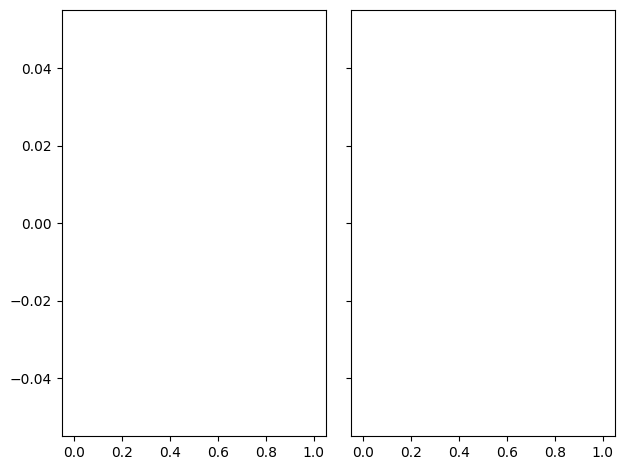

In [44]:
import matplotlib.pyplot as plt
plot_df = df_result.filter(pl.col('dist1') < 10000)
n_bins = 100
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the *bins* keyword argument.
axs[0].hist(plot_df['dist1'], bins=n_bins)
axs[1].hist(plot_df['dist2'], bins=n_bins)

plt.show()

In [ ]:
def make_candidate_first_stage(country_df, n_neighbors,columns):
    concat_df = []
    knn = KNeighborsRegressor(n_neighbors=min(len(country_df), n_neighbors), 
                              metric="euclidean", n_jobs=-1)
    knn.fit(country_df[['latitude','longitude']], country_df.index)
    dists, nears = knn.kneighbors(country_df[['latitude','longitude']], return_distance=True)

    for i in range(min(len(country_df), n_neighbors)):
        country_df_ = country_df[columns].copy()
        country_df_["rank"] = i
        country_df_["d_near"] = dists[:, i]
        for c in columns:
            country_df_[f"near_{c}"] = country_df_[c].values[nears[:, i]]
        concat_df.append(country_df_)
    concat_df = pd.concat(concat_df).reset_index(drop=True)
    return concat_df

In [ ]:
df.plot.scatter(x="drv_longitude", y="drv_latitude", by="glider_name")

Make a plot check

In [ ]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()

plt_df = gdat_df[gdat_df['drv_proIDs'] == 604]
sc = ax.scatter(plt_df['drv_mtime_sci'], plt_df['drv_depth_gli'], c = plt_df['drv_proIDs'])

#set the plot color bar
cbar = plt.colorbar(sc, ax = ax, label='Date')
cbar.set_label('Date', rotation=270, labelpad=15)

#set the depth axis
plt.gca().invert_yaxis()

# set the plot title
ax.set_title("Position of the gliders")
plt.show()